In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz, debug

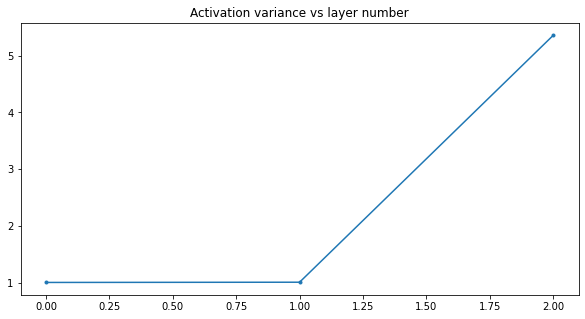

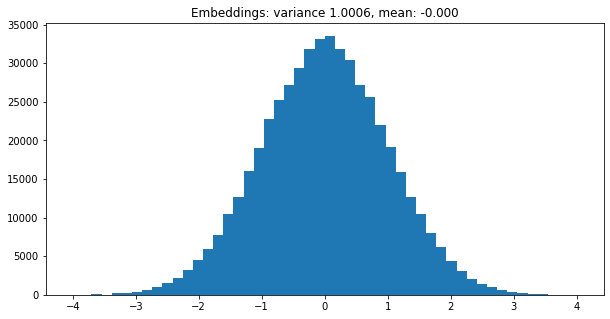

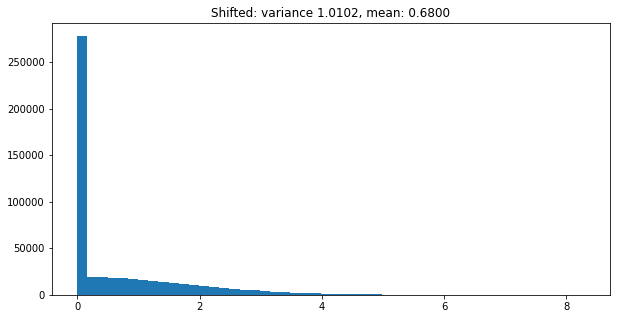

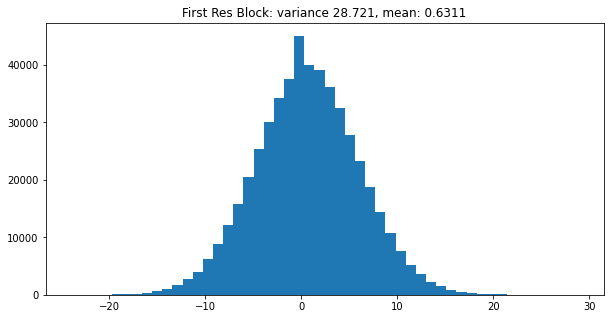

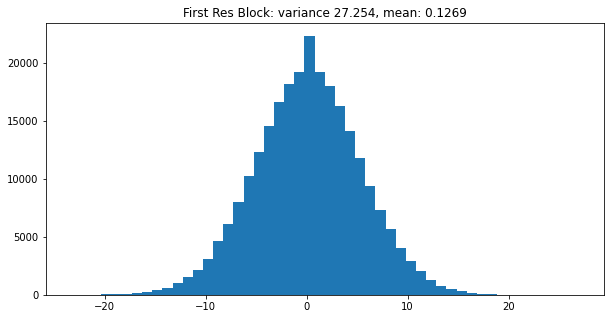

In [3]:
p = model.HParams(embed_inputs=True, mixed_precision=False)
m = model.Wavenet(p)

# capture activations
memo = {}
debug.activations(m, memo)
x = torch.randint(p.n_classes, (10, p.n_audio_chans, 100), dtype=torch.long)
_ = m(x, x)

# activation functions may be missing. add them back in
plt.figure(figsize=(10, 5))
plt.title(f'Activation variance vs layer number')
xs = [
    res
    for k, (res, *_) 
    in memo.items()
]

# add in relus where they are not in the forward function
for i in [1, -1, -2]:
    xs[i] = F.relu(xs[i])
    
xs = [
    x.std().item()
    for x
    in xs
]
    
# plot the results
xs = xs[:3]
plt.plot(range(len(xs)), xs, marker='.')

def fn(title, layer_index, activation=lambda x: x):
    _, activations = list(memo.items())[layer_index]
    if type(activations) == torch.Tensor:
        activations = [activations]
    for x in list(activations):
        x = x.detach().numpy().flatten()
        x = activation(torch.from_numpy(x)).numpy()
        plt.figure(figsize=(10, 5))
        plt.title(f"{title}: variance {str(x.var())[:6]}, mean: {str(x.mean())[:6]}")
        plt.hist(x, 50)
        plt.show()
        plt.close()
        
fn('Embeddings', 0)
fn('Shifted', 1, F.relu)
fn('First Res Block', 2)